In this script we used SMOTE and ML techniques (Logistic regression, random forrest, gradient boosting). And we test different time interval to select the best timing for prediction. 

# LIBRARIES

In [1]:
%run library_TS.py
%run library_discrete.py

Python version: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
NumPy version: 1.23.5
pandas version: 1.5.3
matplotlib: 3.7.1
TSfresh: 0.20.0
Sklearn version: 1.1.3


c:\Users\Windows\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Xgboost version: 1.5.0
Lightgbm version: 2.2.3
Python version: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
NumPy version: 1.23.5
pandas version: 1.5.3
matplotlib: 3.7.1
seaborn: 3.7.1
Sklearn version: 1.1.3
LightGBM: 2.2.3
XGBoost: 1.5.0
TensorFlow: 2.12.0
SHAP: 0.41.0
missingno: 0.5.2
imblearn: 0.10.1


Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons


joblib: 1.1.1
tableone: 0.7.12


# LOAD THE FILES

In [2]:
# Datas importation
data_48H = pd.read_csv("//wsl.localhost/Ubuntu/home/romain/GITHUB/Extub-IA/TimeSeries/Features_extraction/Features_extraction_48H/Filtered features extracted (150 features).csv")
data_24H = pd.read_csv("//wsl.localhost/Ubuntu/home/romain/GITHUB/Extub-IA/TimeSeries/Features_extraction/Features_extraction_24H/Filtered features extracted (150 features).csv")
data_12H = pd.read_csv("//wsl.localhost/Ubuntu/home/romain/GITHUB/Extub-IA/TimeSeries/Features_extraction/Features_extraction_12H/Filtered features extracted (150 features).csv")
data_2H = pd.read_csv("//wsl.localhost/Ubuntu/home/romain/GITHUB/Extub-IA/TimeSeries/Features_extraction/Features_extraction_2H/Filtered features extracted (150 features).csv")

# Target
target_df = pd.read_excel("//wsl.localhost/Ubuntu/home/romain/GITHUB/Extub-IA/BDD/Target.xls", dtype=str, index_col=None, usecols=["ID", "Weaning_success"])

# Drop useless columns of the TS dataset 
X_48H = data_48H.iloc[: , 1:]
X_24H = data_24H.iloc[: , 1:]
X_12H = data_12H.iloc[: , 1:]
X_2H = data_2H.iloc[: , 1:]

# Select the target 
y = target_df["Weaning_success"]

# Descriptives statistics
print("Nombre d'echec de sevrage : ")
print(target_df.Weaning_success.value_counts())


Nombre d'echec de sevrage : 
1    138
0     75
Name: Weaning_success, dtype: int64


In [3]:
############# Imputation by KNN method
scaler = MinMaxScaler() # First Standardization
X_48H_scalar = pd.DataFrame(scaler.fit_transform(X_48H), columns = X_48H.columns)
X_24H_scalar = pd.DataFrame(scaler.fit_transform(X_24H), columns = X_24H.columns)
X_12H_scalar = pd.DataFrame(scaler.fit_transform(X_12H), columns = X_12H.columns)
X_2H_scalar = pd.DataFrame(scaler.fit_transform(X_2H), columns = X_2H.columns)

# The KNN method for the imputation, in this case we use 2 neighbors
imputer = KNNImputer(n_neighbors=2)
X_48H_impute = pd.DataFrame(imputer.fit_transform(X_48H_scalar),columns = X_48H_scalar.columns)
X_24H_impute = pd.DataFrame(imputer.fit_transform(X_24H_scalar),columns = X_24H_scalar.columns)
X_12H_impute = pd.DataFrame(imputer.fit_transform(X_12H_scalar),columns = X_12H_scalar.columns)
X_2H_impute = pd.DataFrame(imputer.fit_transform(X_2H_scalar),columns = X_2H_scalar.columns)


In [4]:
############ Oversampling SMOTE :
############ If we use the unfilter dataset


# Divide the full dataset in train and test
X_train_48H, X_test_48H, y_train_48H, y_test_48H= train_test_split(X_48H_impute, y, test_size=0.2, random_state=42, stratify = y)
X_train_24H, X_test_24H, y_train_24H, y_test_24H= train_test_split(X_24H_impute, y, test_size=0.2, random_state=42, stratify = y)
X_train_12H, X_test_12H, y_train_12H, y_test_12H= train_test_split(X_12H_impute, y, test_size=0.2, random_state=42, stratify = y)
X_train_2H, X_test_2H, y_train_2H, y_test_2H= train_test_split(X_2H_impute, y, test_size=0.2, random_state=42, stratify = y)

print("Before SMOTE :\n",y_train_48H.value_counts())

# Script for the SMOTE NC
sm = SMOTE(k_neighbors=3, sampling_strategy=1, random_state=None) #Assign the object column(categorical variable) to the SMOTE NC 
# Sampling strategy = taux d'observation minoritaire à attendre
# K_neighbors = le nombre de plus proches voisins

# Resample the train by the oversampling
X_train_48H, y_train_48H= sm.fit_resample(X_train_48H, y_train_48H)
X_train_24H, y_train_24H= sm.fit_resample(X_train_24H, y_train_24H)
X_train_12H, y_train_12H= sm.fit_resample(X_train_12H, y_train_12H)
X_train_2H, y_train_2H= sm.fit_resample(X_train_2H, y_train_2H)

# summarize the new class distribution

print("\nAfter SMOTE :\n",y_train_48H.value_counts())


Before SMOTE :
 1    110
0     60
Name: Weaning_success, dtype: int64

After SMOTE :
 1    110
0    110
Name: Weaning_success, dtype: int64


# FUNCTION DEFINITION FOR SAVE THE RESULTS

In [5]:
def print_auc(clf,X_train,y_train,X_test,y_test,model_name) :
    """Function for print the AUC and AUC PR and save it """
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, thr = metrics.roc_curve(y_test,  y_pred_proba, pos_label='1')
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label=model_name+" auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    # Data to plot precision - recall curve
    precision, recall, thresholds_log = precision_recall_curve(y_test, y_pred_proba, pos_label='1')
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = metrics.auc(recall, precision)
 
    
    plt.plot(recall, precision,label=model_name+" auc_prc="+str(auc_precision_recall))
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc=4)
    plt.show()
    train_score = accuracy_score(y_train, clf.predict(X_train)) * 100
    test_score = accuracy_score(y_test, clf.predict(X_test)) * 100
    print_score(clf, X_train, y_train, X_test, y_test, train=True)
    print_score(clf, X_train, y_train, X_test, y_test, train=False)
    precision_sc=precision_score(y_test, clf.predict(X_test), average=None)
    recall_sc=recall_score(y_test, clf.predict(X_test), average=None)
    
    f1=metrics.f1_score(y_test, clf.predict(X_test), pos_label='1')
    metriques = {"fpr": fpr,"recall_sc":recall_sc,"precision_sc":precision_sc,"recall":recall,"precision":precision,"model":clf,"tpr": tpr,"test_score":test_score,"train_score":train_score,"f1":f1,"auc_pr":auc_precision_recall,"auc":auc}
    return metriques




def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    """Function to print and save the results in dataframe format"""
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n====================================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n====================================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

# MODEL DEFINITION FOR 48H DATASET

## 1. LOGISTIC REGRESSION (logistic_Reg)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
learning done in 30.85 seconds


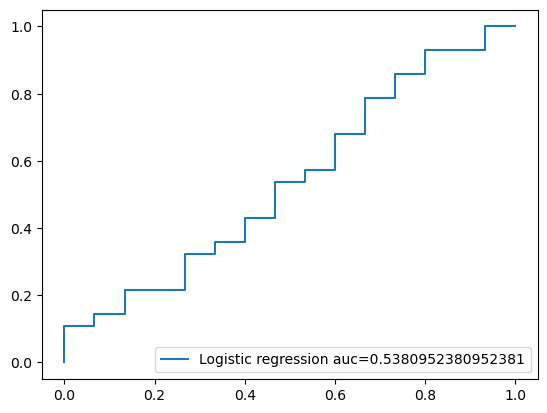

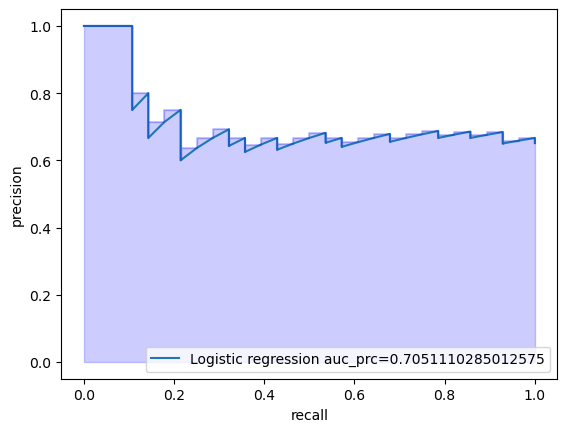

Train Result:
Accuracy Score: 65.00%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.654206    0.646018      0.65    0.650112      0.650112
recall       0.636364    0.663636      0.65    0.650000      0.650000
f1-score     0.645161    0.654709      0.65    0.649935      0.649935
support    110.000000  110.000000      0.65  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[70 40]
 [37 73]]

Test Result:
Accuracy Score: 51.16%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.333333   0.640000  0.511628   0.486667      0.533023
recall      0.400000   0.571429  0.511628   0.485714      0.511628
f1-score    0.363636   0.603774  0.511628   0.483705      0.520005
support    15.000000  28.000

In [6]:
###################### GRIDSEARCH ###########################################
logistic_Reg = LogisticRegression()

parameters = {                              #Definition of the parameters to test
    'max_iter': [50, 150, 300, 500,1000],
    'penalty' : ['l1','l2', 'elasticnet', 'none'], 
    'C': [0.1, 1, 10, 100, 1000],
    'solver' : ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs']
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(logistic_Reg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_48H,y_train_48H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################
# Logistic Regression model creation with the best parameters definites previously

logistic_Reg = LogisticRegression(**clf.best_params_).fit(X_train_48H, y_train_48H)

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_48H,logistic_Reg.predict_proba(X_test_48H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_48H, logistic_Reg.predict_proba(X_test_48H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = logistic_Reg.predict_proba(X_test_48H)[:,1]
pred_test_full +=pred_test

#Save the different results 
y_pred = logistic_Reg.predict(X_test_48H)

logistic_Reg_clf=print_auc(logistic_Reg,X_train_48H,y_train_48H,X_test_48H,y_test_48H,"Logistic regression")

logistic_Reg_cm=confusion_matrix(y_test_48H,logistic_Reg.predict(X_test_48H))

results_df = pd.DataFrame(data=[["Logistic Regression", logistic_Reg_clf["f1"], logistic_Reg_clf["auc"],logistic_Reg_clf["auc_pr"],
                                 logistic_Reg_clf["recall_sc"][0],logistic_Reg_clf["recall_sc"][1],logistic_Reg_clf["precision_sc"][0],logistic_Reg_clf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])

## 2. Random Classifier (RFC)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
learning done in 109.45 seconds


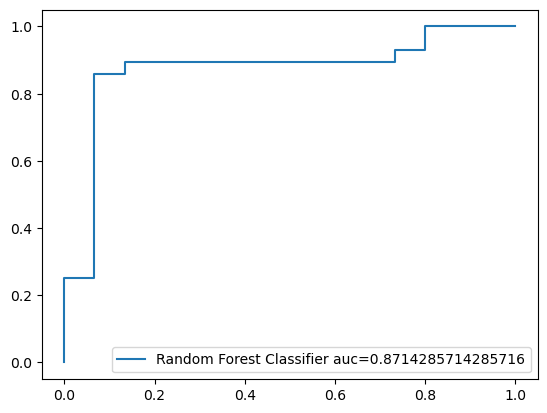

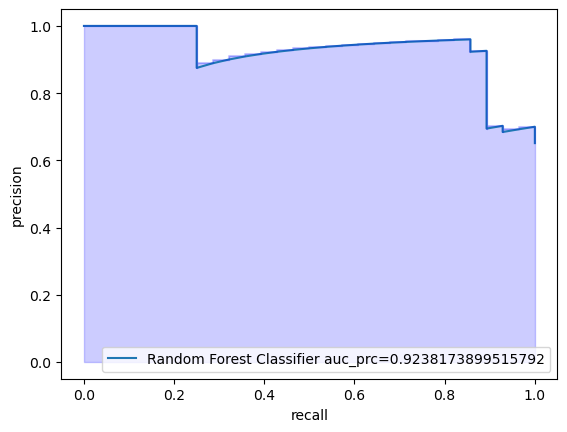

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 83.72%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.700000   0.956522  0.837209   0.828261      0.867037
recall      0.933333   0.785714  0.837209   0.859524      0.837209
f1-score    0.800000   0.862745  0.837209   0.831373      0.840857
support    15.000000  28.000000  0.837209  43.000000     43.000000
___________

In [7]:
###################### GRIDSEARCH ###########################################
RFC = RandomForestClassifier()

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(RFC,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_48H,y_train_48H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL################################

RFC = RandomForestClassifier(**clf.best_params_).fit(X_train_48H, y_train_48H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE #############################################
score = roc_auc_score(y_test_48H,RFC.predict_proba(X_test_48H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_48H, RFC.predict_proba(X_test_48H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = RFC.predict_proba(X_test_48H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = RFC.predict(X_test_48H)

clf_rdf=print_auc(RFC,X_train_48H,y_train_48H,X_test_48H,y_test_48H,"Random Forest Classifier") #Affichage de l'AUC
rdf_cm=confusion_matrix(y_test_48H,RFC.predict(X_test_48H))

#Save the results
results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", clf_rdf["f1"], clf_rdf["auc"],clf_rdf["auc_pr"],clf_rdf["recall_sc"][0],clf_rdf["recall_sc"][1],
                                   clf_rdf["precision_sc"][0],clf_rdf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3.XGBoost (XGB)

{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 200, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'nthread': 4, 'seed': 42, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
learning done in 97.74 seconds


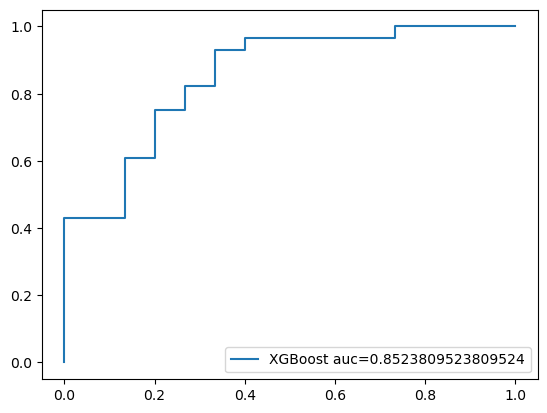

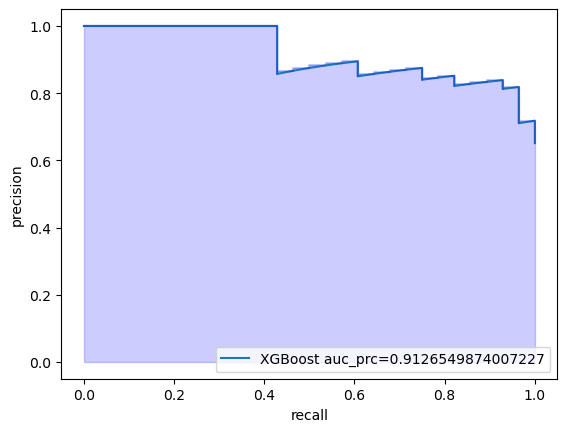

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 79.07%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.714286   0.827586  0.790698   0.770936      0.788063
recall      0.666667   0.857143  0.790698   0.761905      0.790698
f1-score    0.689655   0.842105  0.790698   0.765880      0.788925
support    15.000000  28.000000  0.790698  43.000000     43.000000
___________

In [8]:
###################### GRIDSEARCH ###########################################
XGB = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0
)

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(XGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_48H,y_train_48H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

XGB=XGBClassifier(objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0,
    **clf.best_params_).fit(X_train_48H, y_train_48H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_48H,XGB.predict_proba(X_test_48H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_48H, XGB.predict_proba(X_test_48H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = XGB.predict_proba(X_test_48H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = XGB.predict(X_test_48H)

clf_xgb=print_auc(XGB,X_train_48H,y_train_48H,X_test_48H,y_test_48H,"XGBoost") #Affichage de l'AUC
xgb_cm=confusion_matrix(y_test_48H,XGB.predict(X_test_48H))

#Save the results
results_df_2 = pd.DataFrame(data=[["XGBoost", clf_xgb["f1"], clf_xgb["auc"],clf_xgb["auc_pr"],clf_xgb["recall_sc"][0],clf_xgb["recall_sc"][1],
                                   clf_xgb["precision_sc"][0],clf_xgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 4. LightGBM (LGB)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 10, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 20, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.01, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 2000, 'metric': 'auc'}
learning done in 289.87 seconds


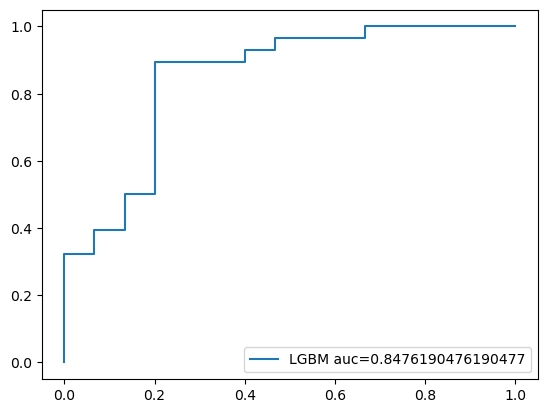

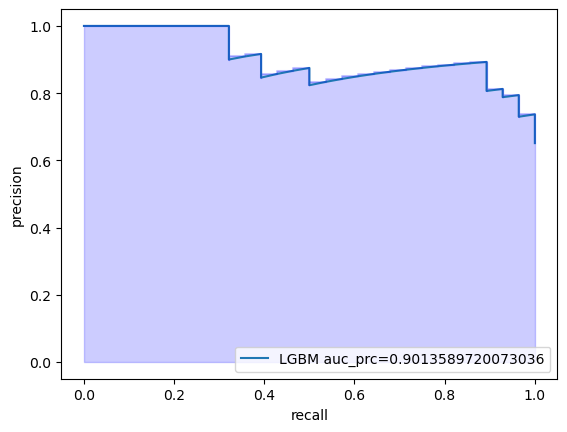

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 83.72%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.785714   0.862069  0.837209   0.823892      0.835434
recall      0.733333   0.892857  0.837209   0.813095      0.837209
f1-score    0.758621   0.877193  0.837209   0.817907      0.835831
support    15.000000  28.000000  0.837209  43.000000     43.000000
___________

In [9]:
###################### GRIDSEARCH ###########################################
LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                         objective='binary', 
                         num_boost_round=2000, 
                         learning_rate=0.01, 
                         metric='auc')

parameters = {'num_leaves':[20,40,60,80,100], 
            'min_child_samples':[5,10,15],
            'max_depth':[-1,5,10,20],
            'learning_rate':[0.05,0.1,0.2],
            'reg_alpha':[0,0.01,0.03]}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(LGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_48H,y_train_48H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                        objective='binary', 
                        num_boost_round=2000, 
                        metric='auc',
                        **clf.best_params_).fit(X_train_48H, y_train_48H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_48H,LGB.predict_proba(X_test_48H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_48H, LGB.predict_proba(X_test_48H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = LGB.predict_proba(X_test_48H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = LGB.predict(X_test_48H)

clf_lgb=print_auc(LGB,X_train_48H,y_train_48H,X_test_48H,y_test_48H,"LGBM") #Affichage de l'AUC
lgb_cm=confusion_matrix(y_test_48H,LGB.predict(X_test_48H))

#Save the results
results_df_2 = pd.DataFrame(data=[["LGBM", clf_lgb["f1"], clf_lgb["auc"],clf_lgb["auc_pr"],clf_lgb["recall_sc"][0],clf_lgb["recall_sc"][1],
                                   clf_lgb["precision_sc"][0],clf_lgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 5. SVC (svc)

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
learning done in 0.82 seconds


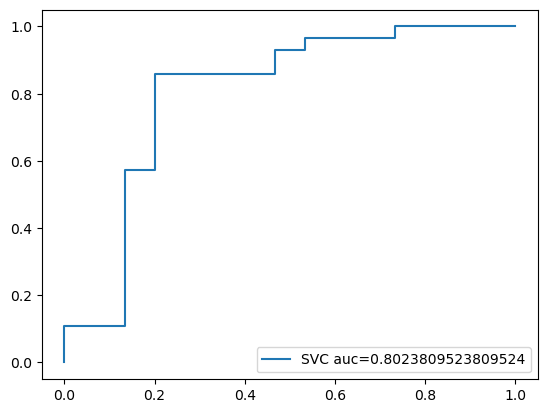

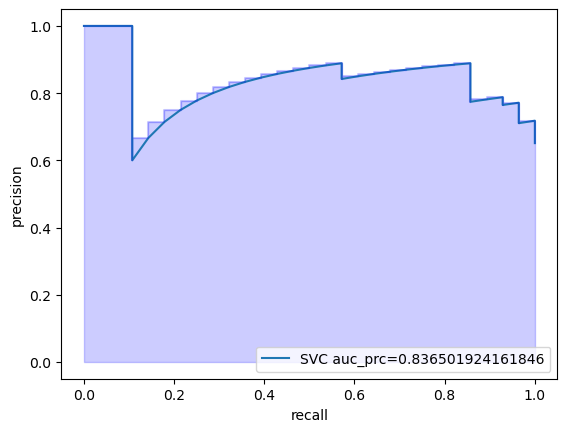

Train Result:
Accuracy Score: 99.09%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.982143  0.990909    0.991071      0.991071
recall       0.981818    1.000000  0.990909    0.990909      0.990909
f1-score     0.990826    0.990991  0.990909    0.990908      0.990908
support    110.000000  110.000000  0.990909  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[108   2]
 [  0 110]]

Test Result:
Accuracy Score: 79.07%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.714286   0.827586  0.790698   0.770936      0.788063
recall      0.666667   0.857143  0.790698   0.761905      0.790698
f1-score    0.689655   0.842105  0.790698   0.765880      0.788925
support    15.000000  28

In [10]:
###################### GRIDSEARCH ###########################################
svc = SVC(probability=True)

parameters = {'C':[1,10,100],
            'gamma':[1,0.1,0.001], 
            'kernel':['linear','rbf', 'sigmoid']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(svc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_48H,y_train_48H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

svc = SVC(**clf.best_params_, probability=True).fit(X_train_48H, y_train_48H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_48H,svc.predict_proba(X_test_48H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_48H, svc.predict_proba(X_test_48H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = svc.predict_proba(X_test_48H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = svc.predict(X_test_48H)

clf_svc=print_auc(svc,X_train_48H,y_train_48H,X_test_48H,y_test_48H,"SVC") #Affichage de l'AUC
svc_cm=confusion_matrix(y_test_48H,svc.predict(X_test_48H))

#Save the results
results_df_2 = pd.DataFrame(data=[["SVC", clf_svc["f1"], clf_svc["auc"],clf_svc["auc_pr"],clf_svc["recall_sc"][0],clf_svc["recall_sc"][1],
                                   clf_svc["precision_sc"][0],clf_svc["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 6. Naive Bayes (GNB)

{'priors': None, 'var_smoothing': 0.01}
learning done in 0.17 seconds


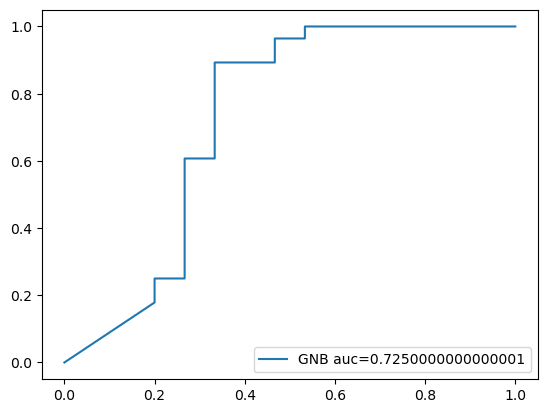

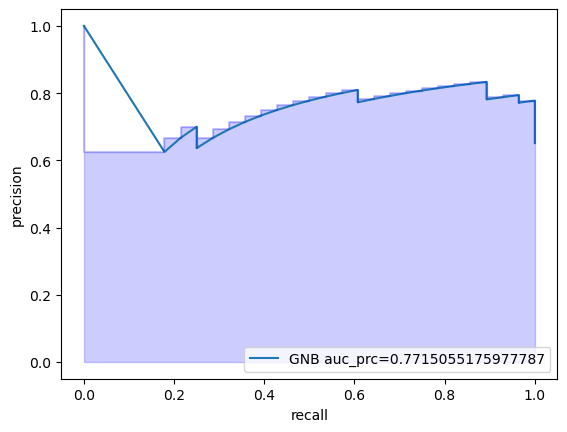

Train Result:
Accuracy Score: 74.09%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.680272    0.863014  0.740909    0.771643      0.771643
recall       0.909091    0.572727  0.740909    0.740909      0.740909
f1-score     0.778210    0.688525  0.740909    0.733367      0.733367
support    110.000000  110.000000  0.740909  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[100  10]
 [ 47  63]]

Test Result:
Accuracy Score: 62.79%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.478261   0.800000  0.627907   0.639130      0.687765
recall      0.733333   0.571429  0.627907   0.652381      0.627907
f1-score    0.578947   0.666667  0.627907   0.622807      0.636067
support    15.000000  28

In [11]:
###################### GRIDSEARCH ###########################################
GNB = GaussianNB()

parameters = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
              
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(GNB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_48H,y_train_48H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

GNB = GaussianNB(**clf.best_params_).fit(X_train_48H, y_train_48H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_48H,GNB.predict_proba(X_test_48H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_48H, GNB.predict_proba(X_test_48H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = GNB.predict_proba(X_test_48H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = GNB.predict(X_test_48H)

clf_gnb=print_auc(GNB,X_train_48H,y_train_48H,X_test_48H,y_test_48H,"GNB") #Affichage de l'AUC
gnb_cm=confusion_matrix(y_test_48H,GNB.predict(X_test_48H))

#Save the results
results_df_2 = pd.DataFrame(data=[["GNB",clf_gnb["f1"],clf_gnb["auc"],clf_gnb["auc_pr"],clf_gnb["recall_sc"][0],clf_gnb["recall_sc"][1],
                                   clf_gnb["precision_sc"][0],clf_gnb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 7. KNN (KNN)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
learning done in 16.64 seconds


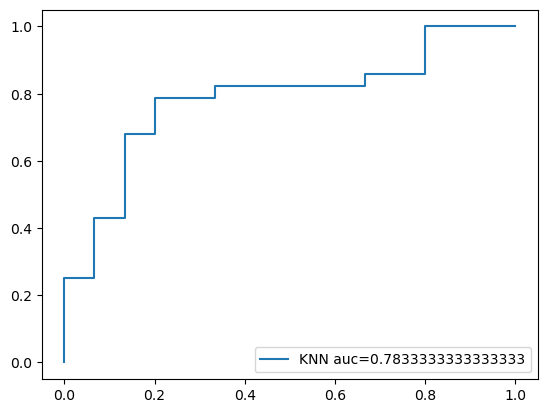

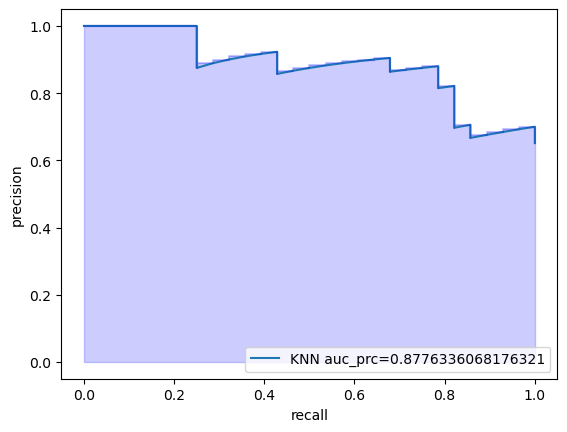

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 72.09%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.571429   0.863636   0.72093   0.717532      0.761703
recall      0.800000   0.678571   0.72093   0.739286      0.720930
f1-score    0.666667   0.760000   0.72093   0.713333      0.727442
support    15.000000  28.000000   0.72093  43.000000     43.000000
___________

In [12]:
###################### GRIDSEARCH ###########################################
KNN = KNeighborsClassifier()

k_range = list(range(1, 31)) # Definition of number neighbors
parameters = {
            'n_neighbors' : k_range,
            'weights': ['uniform', 'distance'],
            'metric' : ['manhattan']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(KNN,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_48H,y_train_48H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

KNN = KNeighborsClassifier(**clf.best_params_).fit(X_train_48H, y_train_48H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_48H,KNN.predict_proba(X_test_48H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_48H, KNN.predict_proba(X_test_48H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = KNN.predict_proba(X_test_48H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = KNN.predict(X_test_48H)

clf_knn=print_auc(KNN,X_train_48H,y_train_48H,X_test_48H,y_test_48H,"KNN") #Affichage de l'AUC
knn_cm=confusion_matrix(y_test_48H,KNN.predict(X_test_48H))

#Save the results
results_df_2 = pd.DataFrame(data=[["KNN",clf_knn["f1"],clf_knn["auc"],clf_knn["auc_pr"],clf_knn["recall_sc"][0],clf_knn["recall_sc"][1],
                                   clf_knn["precision_sc"][0],clf_knn["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

In [13]:
results_df.to_csv('results for 48H dataset.csv', index=True)

# MODELS FOR 24H DATASET

## 1. LOGISTIC REGRESSION (logistic_Reg)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
learning done in 30.76 seconds


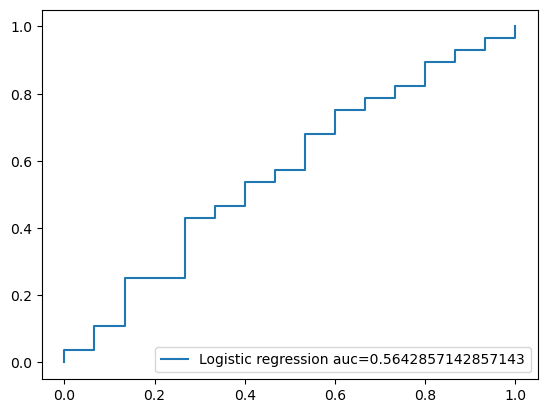

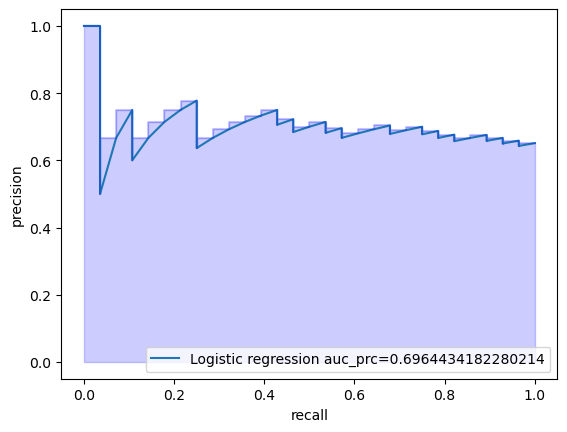

Train Result:
Accuracy Score: 64.09%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.634783    0.647619  0.640909    0.641201      0.641201
recall       0.663636    0.618182  0.640909    0.640909      0.640909
f1-score     0.648889    0.632558  0.640909    0.640724      0.640724
support    110.000000  110.000000  0.640909  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[73 37]
 [42 68]]

Test Result:
Accuracy Score: 55.81%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.400000   0.695652   0.55814   0.547826      0.592518
recall      0.533333   0.571429   0.55814   0.552381      0.558140
f1-score    0.457143   0.627451   0.55814   0.542297      0.568041
support    15.000000  28.000

In [14]:
###################### GRIDSEARCH ###########################################
logistic_Reg = LogisticRegression()

parameters = {                              #Definition of the parameters to test
    'max_iter': [50, 150, 300, 500,1000],
    'penalty' : ['l1','l2', 'elasticnet', 'none'], 
    'C': [0.1, 1, 10, 100, 1000],
    'solver' : ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs']
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(logistic_Reg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_24H,y_train_24H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################
# Logistic Regression model creation with the best parameters definites previously

logistic_Reg = LogisticRegression(**clf.best_params_).fit(X_train_24H, y_train_24H)

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_24H,logistic_Reg.predict_proba(X_test_24H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_24H, logistic_Reg.predict_proba(X_test_24H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = logistic_Reg.predict_proba(X_test_24H)[:,1]
pred_test_full +=pred_test

#Save the different results 
y_pred = logistic_Reg.predict(X_test_24H)

logistic_Reg_clf=print_auc(logistic_Reg,X_train_24H,y_train_24H,X_test_24H,y_test_24H,"Logistic regression")

logistic_Reg_cm=confusion_matrix(y_test_24H,logistic_Reg.predict(X_test_24H))

results_df = pd.DataFrame(data=[["Logistic Regression", logistic_Reg_clf["f1"], logistic_Reg_clf["auc"],logistic_Reg_clf["auc_pr"],
                                 logistic_Reg_clf["recall_sc"][0],logistic_Reg_clf["recall_sc"][1],logistic_Reg_clf["precision_sc"][0],logistic_Reg_clf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])

## 2. Random Classifier (RFC)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
learning done in 113.82 seconds


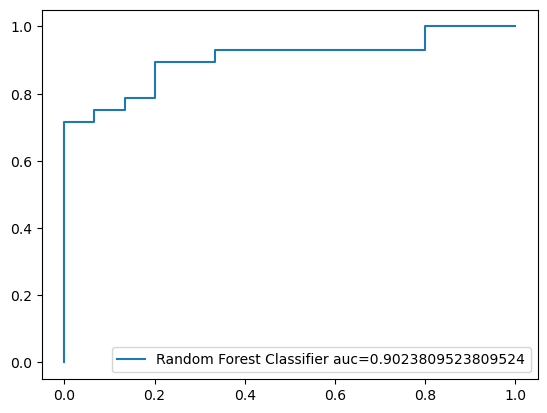

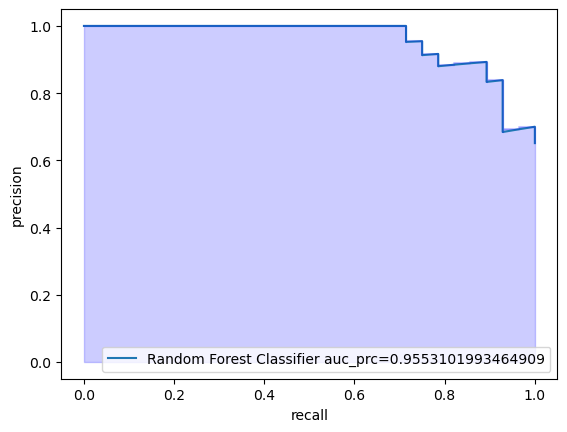

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 83.72%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.833333   0.838710  0.837209   0.836022      0.836834
recall      0.666667   0.928571  0.837209   0.797619      0.837209
f1-score    0.740741   0.881356  0.837209   0.811048      0.832304
support    15.000000  28.000000  0.837209  43.000000     43.000000
___________

In [15]:
###################### GRIDSEARCH ###########################################
RFC = RandomForestClassifier()

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(RFC,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_24H,y_train_24H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

RFC = RandomForestClassifier(**clf.best_params_).fit(X_train_24H, y_train_24H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_24H,RFC.predict_proba(X_test_24H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_24H, RFC.predict_proba(X_test_24H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = RFC.predict_proba(X_test_24H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = RFC.predict(X_test_24H)

clf_rdf=print_auc(RFC,X_train_24H,y_train_24H,X_test_24H,y_test_24H,"Random Forest Classifier") #Affichage de l'AUC
rdf_cm=confusion_matrix(y_test_24H,RFC.predict(X_test_24H))

#Save the results
results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", clf_rdf["f1"], clf_rdf["auc"],clf_rdf["auc_pr"],clf_rdf["recall_sc"][0],clf_rdf["recall_sc"][1],
                                   clf_rdf["precision_sc"][0],clf_rdf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3. XGBoost (XGB)

{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'nthread': 4, 'seed': 42, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
learning done in 105.15 seconds


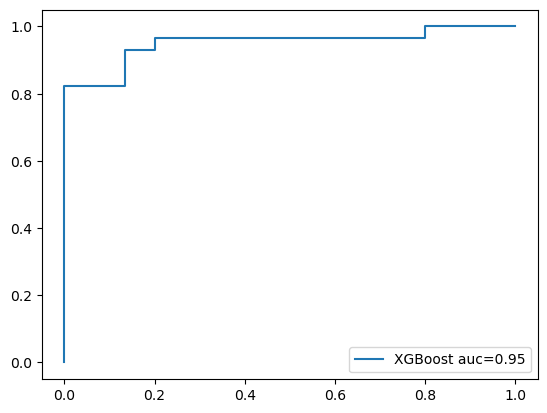

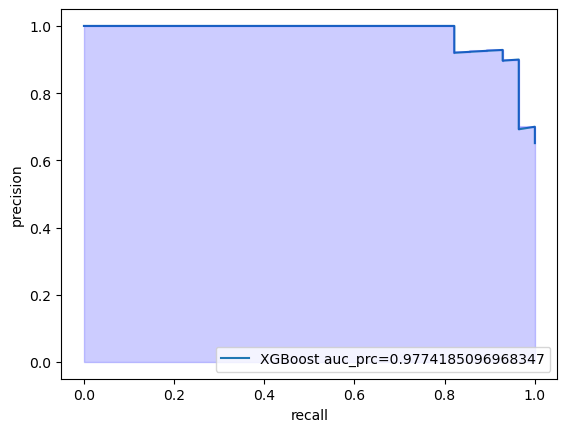

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 88.37%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.857143   0.896552  0.883721   0.876847      0.882804
recall      0.800000   0.928571  0.883721   0.864286      0.883721
f1-score    0.827586   0.912281  0.883721   0.869933      0.882736
support    15.000000  28.000000  0.883721  43.000000     43.000000
___________

In [16]:
###################### GRIDSEARCH ###########################################
XGB = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0
)

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(XGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_24H,y_train_24H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

XGB=XGBClassifier(objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0,
    **clf.best_params_).fit(X_train_24H, y_train_24H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_24H,XGB.predict_proba(X_test_24H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_24H, XGB.predict_proba(X_test_24H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = XGB.predict_proba(X_test_24H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = XGB.predict(X_test_24H)

clf_xgb=print_auc(XGB,X_train_24H,y_train_24H,X_test_24H,y_test_24H,"XGBoost") #Affichage de l'AUC
xgb_cm=confusion_matrix(y_test_24H,XGB.predict(X_test_24H))

#Save the results
results_df_2 = pd.DataFrame(data=[["XGBoost", clf_xgb["f1"], clf_xgb["auc"],clf_xgb["auc_pr"],clf_xgb["recall_sc"][0],clf_xgb["recall_sc"][1],
                                   clf_xgb["precision_sc"][0],clf_xgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3. LightGBM (LGB)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 40, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 2000, 'metric': 'auc'}
learning done in 292.60 seconds


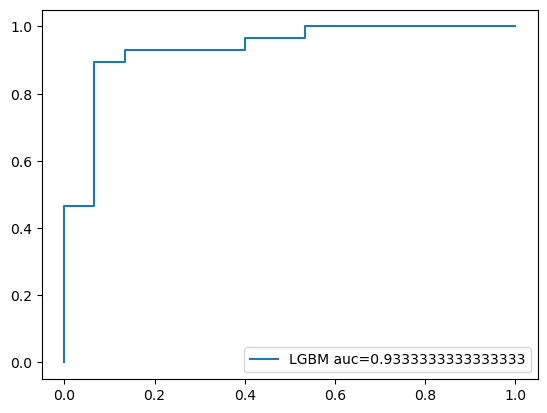

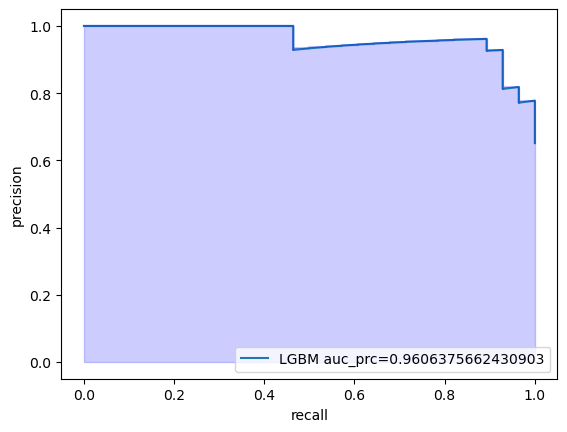

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 86.05%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.846154   0.866667  0.860465   0.856410      0.859511
recall      0.733333   0.928571  0.860465   0.830952      0.860465
f1-score    0.785714   0.896552  0.860465   0.841133      0.857888
support    15.000000  28.000000  0.860465  43.000000     43.000000
___________

In [17]:
###################### GRIDSEARCH ###########################################
LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                         objective='binary', 
                         num_boost_round=2000, 
                         learning_rate=0.01, 
                         metric='auc')

parameters = {'num_leaves':[20,40,60,80,100], 
            'min_child_samples':[5,10,15],
            'max_depth':[-1,5,10,20],
            'learning_rate':[0.05,0.1,0.2],
            'reg_alpha':[0,0.01,0.03]}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(LGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_24H,y_train_24H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                        objective='binary', 
                        num_boost_round=2000, 
                        metric='auc',
                        **clf.best_params_).fit(X_train_24H, y_train_24H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_24H,LGB.predict_proba(X_test_24H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_24H, LGB.predict_proba(X_test_24H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = LGB.predict_proba(X_test_24H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = LGB.predict(X_test_24H)

clf_lgb=print_auc(LGB,X_train_24H,y_train_24H,X_test_24H,y_test_24H,"LGBM") #Affichage de l'AUC
lgb_cm=confusion_matrix(y_test_24H,LGB.predict(X_test_24H))

#Save the results
results_df_2 = pd.DataFrame(data=[["LGBM", clf_lgb["f1"], clf_lgb["auc"],clf_lgb["auc_pr"],clf_lgb["recall_sc"][0],clf_lgb["recall_sc"][1],
                                   clf_lgb["precision_sc"][0],clf_lgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 4. SVC (svc)

{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
learning done in 0.79 seconds


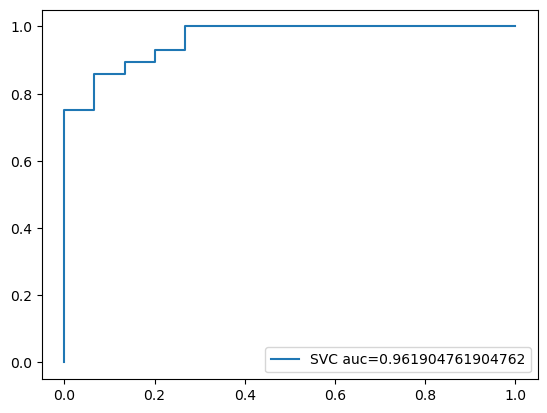

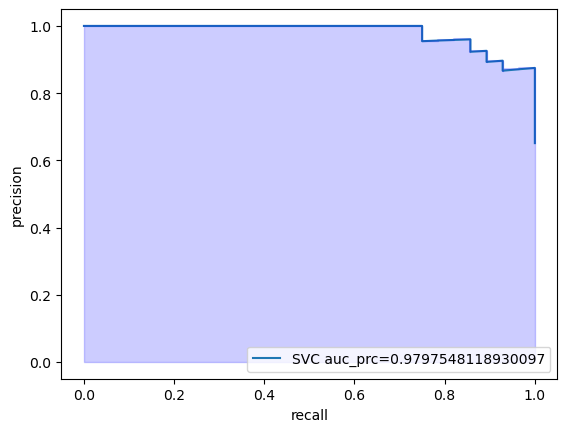

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 90.70%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   1.000000   0.875000  0.906977   0.937500      0.918605
recall      0.733333   1.000000  0.906977   0.866667      0.906977
f1-score    0.846154   0.933333  0.906977   0.889744      0.902922
support    15.000000  28.000000  0.906977  43.000000     43.000000
___________

In [18]:
###################### GRIDSEARCH ###########################################
svc = SVC(probability=True)

parameters = {'C':[1,10,100],
            'gamma':[1,0.1,0.001], 
            'kernel':['linear','rbf', 'sigmoid']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(svc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_24H,y_train_24H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

svc = SVC(**clf.best_params_, probability=True).fit(X_train_24H, y_train_24H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_24H,svc.predict_proba(X_test_24H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_24H, svc.predict_proba(X_test_24H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = svc.predict_proba(X_test_24H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = svc.predict(X_test_24H)

clf_svc=print_auc(svc,X_train_24H,y_train_24H,X_test_24H,y_test_24H,"SVC") #Affichage de l'AUC
svc_cm=confusion_matrix(y_test_24H,svc.predict(X_test_24H))

#Save the results
results_df_2 = pd.DataFrame(data=[["SVC", clf_svc["f1"], clf_svc["auc"],clf_svc["auc_pr"],clf_svc["recall_sc"][0],clf_svc["recall_sc"][1],
                                   clf_svc["precision_sc"][0],clf_svc["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 5. Naive Bayes (GNB)

{'priors': None, 'var_smoothing': 1e-09}
learning done in 0.16 seconds


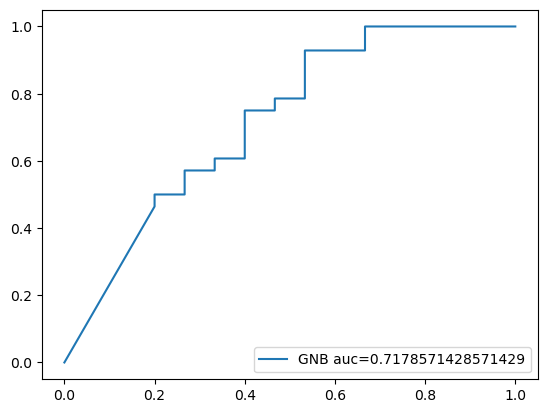

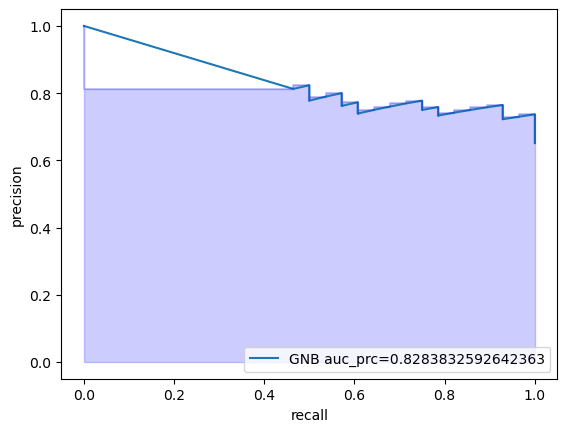

Train Result:
Accuracy Score: 77.73%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.725926    0.858824  0.777273    0.792375      0.792375
recall       0.890909    0.663636  0.777273    0.777273      0.777273
f1-score     0.800000    0.748718  0.777273    0.774359      0.774359
support    110.000000  110.000000  0.777273  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[98 12]
 [37 73]]

Test Result:
Accuracy Score: 62.79%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.476190   0.772727  0.627907   0.624459      0.669284
recall      0.666667   0.607143  0.627907   0.636905      0.627907
f1-score    0.555556   0.680000  0.627907   0.617778      0.636589
support    15.000000  28.000

In [19]:
###################### GRIDSEARCH ###########################################
GNB = GaussianNB()

parameters = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
              
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(GNB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_24H,y_train_24H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

GNB = GaussianNB(**clf.best_params_).fit(X_train_24H, y_train_24H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_24H,GNB.predict_proba(X_test_24H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_24H, GNB.predict_proba(X_test_24H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = GNB.predict_proba(X_test_24H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = GNB.predict(X_test_24H)

clf_gnb=print_auc(GNB,X_train_24H,y_train_24H,X_test_24H,y_test_24H,"GNB") #Affichage de l'AUC
gnb_cm=confusion_matrix(y_test_24H,GNB.predict(X_test_24H))

#Save the results
results_df_2 = pd.DataFrame(data=[["GNB",clf_gnb["f1"],clf_gnb["auc"],clf_gnb["auc_pr"],clf_gnb["recall_sc"][0],clf_gnb["recall_sc"][1],
                                   clf_gnb["precision_sc"][0],clf_gnb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 6. KNN (KNN)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
learning done in 16.74 seconds


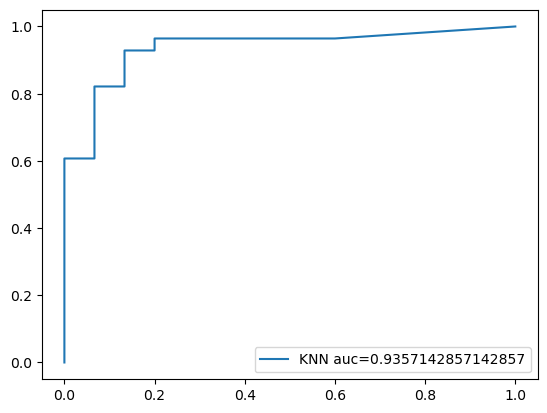

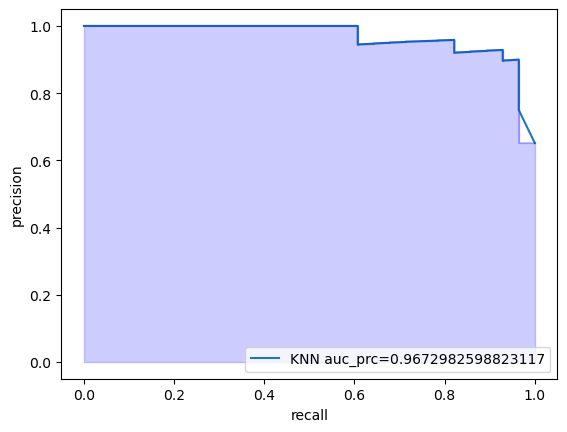

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 74.42%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.583333   0.947368  0.744186   0.765351      0.820379
recall      0.933333   0.642857  0.744186   0.788095      0.744186
f1-score    0.717949   0.765957  0.744186   0.741953      0.749210
support    15.000000  28.000000  0.744186  43.000000     43.000000
___________

In [20]:
###################### GRIDSEARCH ###########################################
KNN = KNeighborsClassifier()

k_range = list(range(1, 31)) # Definition of number neighbors
parameters = {
            'n_neighbors' : k_range,
            'weights': ['uniform', 'distance'],
            'metric' : ['manhattan']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(KNN,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_24H,y_train_24H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

KNN = KNeighborsClassifier(**clf.best_params_).fit(X_train_24H, y_train_24H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_24H,KNN.predict_proba(X_test_24H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_24H, KNN.predict_proba(X_test_24H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = KNN.predict_proba(X_test_24H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = KNN.predict(X_test_24H)

clf_knn=print_auc(KNN,X_train_24H,y_train_24H,X_test_24H,y_test_24H,"KNN") #Affichage de l'AUC
knn_cm=confusion_matrix(y_test_24H,KNN.predict(X_test_24H))

#Save the results
results_df_2 = pd.DataFrame(data=[["KNN",clf_knn["f1"],clf_knn["auc"],clf_knn["auc_pr"],clf_knn["recall_sc"][0],clf_knn["recall_sc"][1],
                                   clf_knn["precision_sc"][0],clf_knn["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

In [21]:
results_df.to_csv('results for 24H dataset.csv', index=True)

# MODELS FOR 12H dataset

## 1. Logistic regression (logistic_Reg)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
learning done in 33.65 seconds


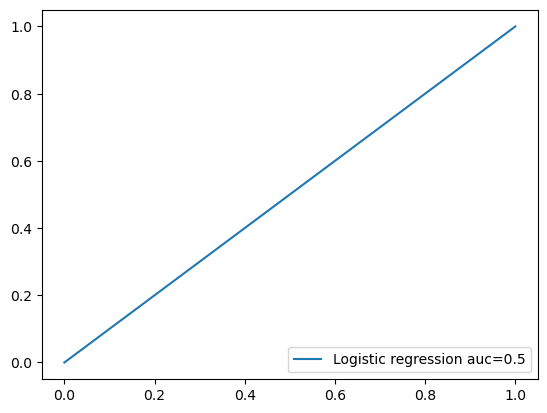

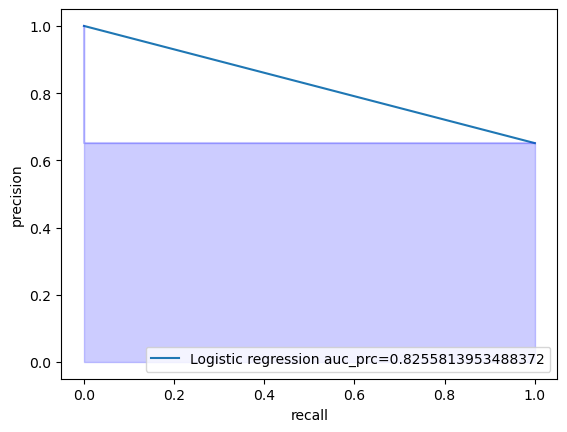

Train Result:
Accuracy Score: 50.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0           1  accuracy   macro avg  weighted avg
precision    0.0    0.500000       0.5    0.250000      0.250000
recall       0.0    1.000000       0.5    0.500000      0.500000
f1-score     0.0    0.666667       0.5    0.333333      0.333333
support    110.0  110.000000       0.5  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[  0 110]
 [  0 110]]

Test Result:
Accuracy Score: 65.12%
________________________________________________________________
CLASSIFICATION REPORT:
              0          1  accuracy  macro avg  weighted avg
precision   0.0   0.651163  0.651163   0.325581      0.424013
recall      0.0   1.000000  0.651163   0.500000      0.651163
f1-score    0.0   0.788732  0.651163   0.394366      0.513593
support    15.0  28.000000  0.651163  43.000000     43.000000
_______

In [22]:
###################### GRIDSEARCH ###########################################
logistic_Reg = LogisticRegression()

parameters = {                              #Definition of the parameters to test
    'max_iter': [50, 150, 300, 500,1000],
    'penalty' : ['l1','l2', 'elasticnet', 'none'], 
    'C': [0.1, 1, 10, 100, 1000],
    'solver' : ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs']
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(logistic_Reg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_12H,y_train_12H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################
# Logistic Regression model creation with the best parameters definites previously

logistic_Reg = LogisticRegression(**clf.best_params_).fit(X_train_12H, y_train_12H)

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_12H,logistic_Reg.predict_proba(X_test_12H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_12H, logistic_Reg.predict_proba(X_test_12H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = logistic_Reg.predict_proba(X_test_12H)[:,1]
pred_test_full +=pred_test

#Save the different results 
y_pred = logistic_Reg.predict(X_test_12H)

logistic_Reg_clf=print_auc(logistic_Reg,X_train_12H,y_train_12H,X_test_12H,y_test_12H,"Logistic regression")

logistic_Reg_cm=confusion_matrix(y_test_12H,logistic_Reg.predict(X_test_12H))

results_df = pd.DataFrame(data=[["Logistic Regression", logistic_Reg_clf["f1"], logistic_Reg_clf["auc"],logistic_Reg_clf["auc_pr"],
                                 logistic_Reg_clf["recall_sc"][0],logistic_Reg_clf["recall_sc"][1],logistic_Reg_clf["precision_sc"][0],logistic_Reg_clf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])

## 2. Random Classifier (RFC)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
learning done in 111.45 seconds


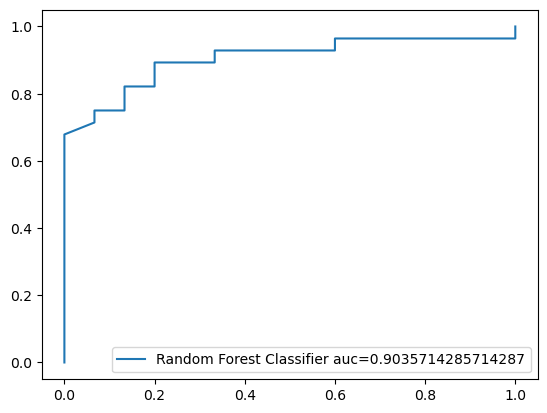

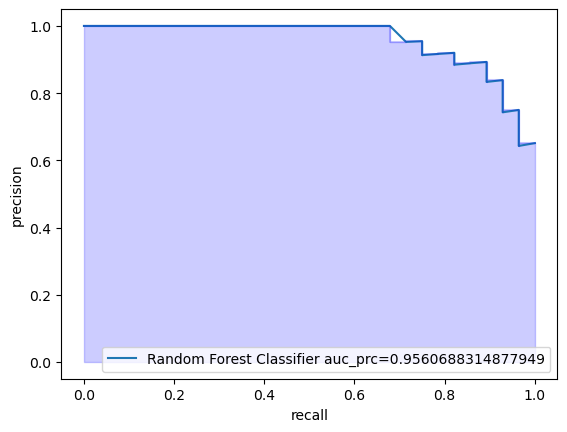

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 83.72%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.785714   0.862069  0.837209   0.823892      0.835434
recall      0.733333   0.892857  0.837209   0.813095      0.837209
f1-score    0.758621   0.877193  0.837209   0.817907      0.835831
support    15.000000  28.000000  0.837209  43.000000     43.000000
___________

In [23]:
###################### GRIDSEARCH ###########################################
RFC = RandomForestClassifier()

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(RFC,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_12H,y_train_12H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

RFC = RandomForestClassifier(**clf.best_params_).fit(X_train_12H, y_train_12H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_12H,RFC.predict_proba(X_test_12H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_12H, RFC.predict_proba(X_test_12H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = RFC.predict_proba(X_test_12H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = RFC.predict(X_test_12H)

clf_rdf=print_auc(RFC,X_train_12H,y_train_12H,X_test_12H,y_test_12H,"Random Forest Classifier") #Affichage de l'AUC
rdf_cm=confusion_matrix(y_test_12H,RFC.predict(X_test_12H))

#Save the results
results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", clf_rdf["f1"], clf_rdf["auc"],clf_rdf["auc_pr"],clf_rdf["recall_sc"][0],clf_rdf["recall_sc"][1],
                                   clf_rdf["precision_sc"][0],clf_rdf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3. XGBoost (XGB)

{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 200, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'nthread': 4, 'seed': 42, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
learning done in 105.52 seconds


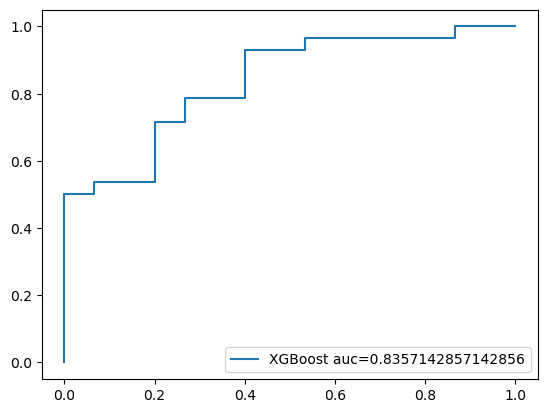

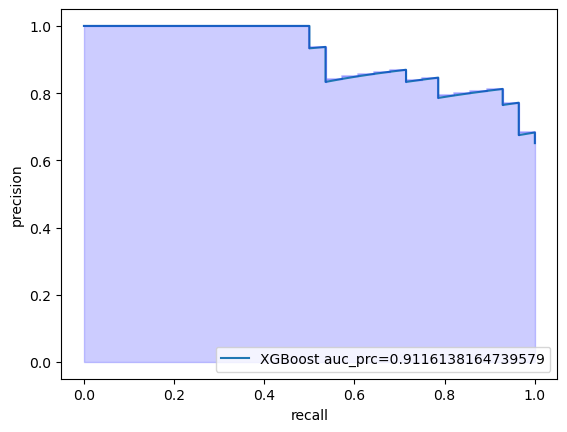

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 74.42%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.642857   0.793103  0.744186   0.717980      0.740692
recall      0.600000   0.821429  0.744186   0.710714      0.744186
f1-score    0.620690   0.807018  0.744186   0.713854      0.742019
support    15.000000  28.000000  0.744186  43.000000     43.000000
___________

In [24]:
###################### GRIDSEARCH ###########################################
XGB = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0
)

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(XGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_12H,y_train_12H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

XGB=XGBClassifier(objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0,
    **clf.best_params_).fit(X_train_12H, y_train_12H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_12H,XGB.predict_proba(X_test_12H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_12H, XGB.predict_proba(X_test_12H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = XGB.predict_proba(X_test_12H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = XGB.predict(X_test_12H)

clf_xgb=print_auc(XGB,X_train_12H,y_train_12H,X_test_12H,y_test_12H,"XGBoost") #Affichage de l'AUC
xgb_cm=confusion_matrix(y_test_12H,XGB.predict(X_test_12H))

#Save the results
results_df_2 = pd.DataFrame(data=[["XGBoost", clf_xgb["f1"], clf_xgb["auc"],clf_xgb["auc_pr"],clf_xgb["recall_sc"][0],clf_xgb["recall_sc"][1],
                                   clf_xgb["precision_sc"][0],clf_xgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 4. LightGBM (LGB)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 10, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 20, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 2000, 'metric': 'auc'}
learning done in 292.84 seconds


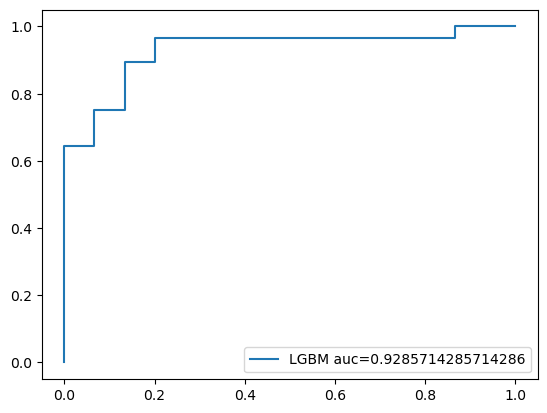

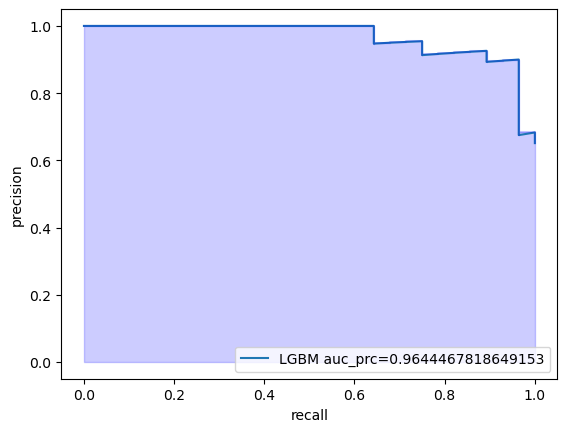

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 88.37%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.812500   0.925926  0.883721   0.869213      0.886359
recall      0.866667   0.892857  0.883721   0.879762      0.883721
f1-score    0.838710   0.909091  0.883721   0.873900      0.884539
support    15.000000  28.000000  0.883721  43.000000     43.000000
___________

In [25]:
###################### GRIDSEARCH ###########################################
LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                         objective='binary', 
                         num_boost_round=2000, 
                         learning_rate=0.01, 
                         metric='auc')

parameters = {'num_leaves':[20,40,60,80,100], 
            'min_child_samples':[5,10,15],
            'max_depth':[-1,5,10,20],
            'learning_rate':[0.05,0.1,0.2],
            'reg_alpha':[0,0.01,0.03]}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(LGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_12H,y_train_12H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                        objective='binary', 
                        num_boost_round=2000, 
                        metric='auc',
                        **clf.best_params_).fit(X_train_12H, y_train_12H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_12H,LGB.predict_proba(X_test_12H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_12H, LGB.predict_proba(X_test_12H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = LGB.predict_proba(X_test_12H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = LGB.predict(X_test_12H)

clf_lgb=print_auc(LGB,X_train_12H,y_train_12H,X_test_12H,y_test_12H,"LGBM") #Affichage de l'AUC
lgb_cm=confusion_matrix(y_test_12H,LGB.predict(X_test_12H))

#Save the results
results_df_2 = pd.DataFrame(data=[["LGBM", clf_lgb["f1"], clf_lgb["auc"],clf_lgb["auc_pr"],clf_lgb["recall_sc"][0],clf_lgb["recall_sc"][1],
                                   clf_lgb["precision_sc"][0],clf_lgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 5. SVC (svc)

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
learning done in 0.85 seconds


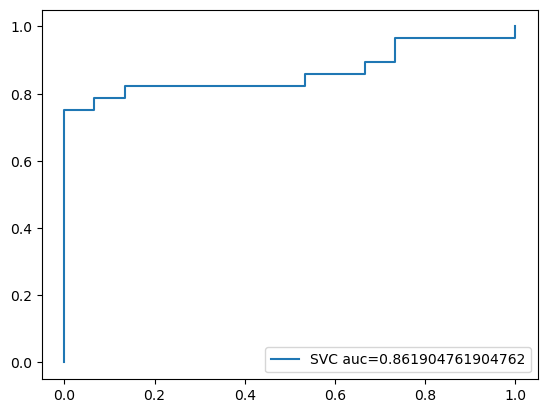

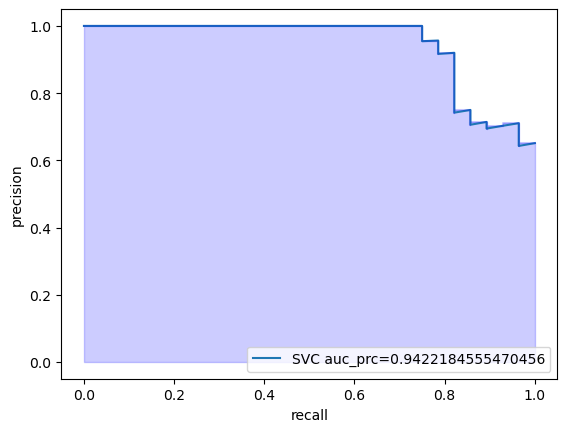

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 69.77%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.750000   0.692308  0.697674   0.721154      0.712433
recall      0.200000   0.964286  0.697674   0.582143      0.697674
f1-score    0.315789   0.805970  0.697674   0.560880      0.634977
support    15.000000  28.000000  0.697674  43.000000     43.000000
___________

In [26]:
###################### GRIDSEARCH ###########################################
svc = SVC(probability=True)

parameters = {'C':[1,10,100],
            'gamma':[1,0.1,0.001], 
            'kernel':['linear','rbf', 'sigmoid']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(svc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_12H,y_train_12H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

svc = SVC(**clf.best_params_, probability=True).fit(X_train_12H, y_train_12H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_12H,svc.predict_proba(X_test_12H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_12H, svc.predict_proba(X_test_12H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = svc.predict_proba(X_test_12H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = svc.predict(X_test_12H)

clf_svc=print_auc(svc,X_train_12H,y_train_12H,X_test_12H,y_test_12H,"SVC") #Affichage de l'AUC
svc_cm=confusion_matrix(y_test_12H,svc.predict(X_test_12H))

#Save the results
results_df_2 = pd.DataFrame(data=[["SVC", clf_svc["f1"], clf_svc["auc"],clf_svc["auc_pr"],clf_svc["recall_sc"][0],clf_svc["recall_sc"][1],
                                   clf_svc["precision_sc"][0],clf_svc["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 6. Naive Bayes (GNB)

{'priors': None, 'var_smoothing': 0.001}
learning done in 0.17 seconds


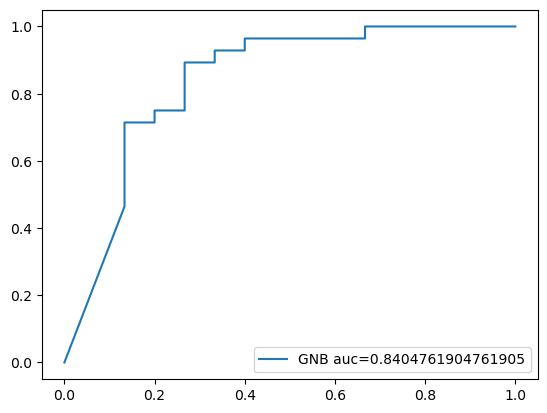

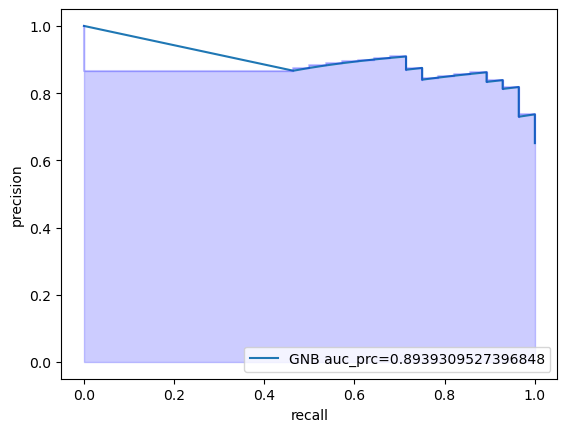

Train Result:
Accuracy Score: 69.55%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.683761    0.708738  0.695455    0.696249      0.696249
recall       0.727273    0.663636  0.695455    0.695455      0.695455
f1-score     0.704846    0.685446  0.695455    0.695146      0.695146
support    110.000000  110.000000  0.695455  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[80 30]
 [37 73]]

Test Result:
Accuracy Score: 76.74%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.619048   0.909091  0.767442   0.764069      0.807913
recall      0.866667   0.714286  0.767442   0.790476      0.767442
f1-score    0.722222   0.800000  0.767442   0.761111      0.772868
support    15.000000  28.000

In [27]:
###################### GRIDSEARCH ###########################################
GNB = GaussianNB()

parameters = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
              
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(GNB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_12H,y_train_12H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

GNB = GaussianNB(**clf.best_params_).fit(X_train_12H, y_train_12H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_12H,GNB.predict_proba(X_test_12H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_12H, GNB.predict_proba(X_test_12H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = GNB.predict_proba(X_test_12H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = GNB.predict(X_test_12H)

clf_gnb=print_auc(GNB,X_train_12H,y_train_12H,X_test_12H,y_test_12H,"GNB") #Affichage de l'AUC
gnb_cm=confusion_matrix(y_test_12H,GNB.predict(X_test_12H))

#Save the results
results_df_2 = pd.DataFrame(data=[["GNB",clf_gnb["f1"],clf_gnb["auc"],clf_gnb["auc_pr"],clf_gnb["recall_sc"][0],clf_gnb["recall_sc"][1],
                                   clf_gnb["precision_sc"][0],clf_gnb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 7. KNN (KNN)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
learning done in 16.67 seconds


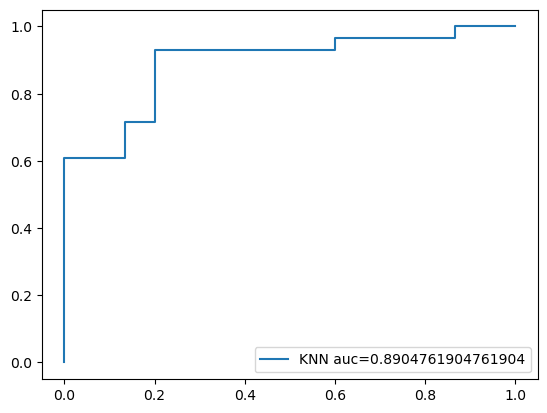

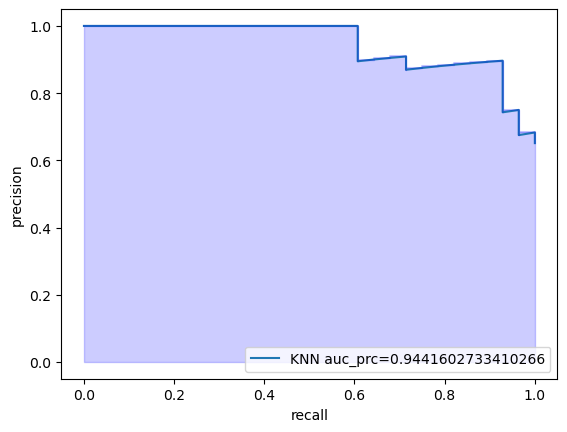

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 72.09%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.565217   0.900000   0.72093   0.732609      0.783215
recall      0.866667   0.642857   0.72093   0.754762      0.720930
f1-score    0.684211   0.750000   0.72093   0.717105      0.727050
support    15.000000  28.000000   0.72093  43.000000     43.000000
___________

In [28]:
###################### GRIDSEARCH ###########################################
KNN = KNeighborsClassifier()

k_range = list(range(1, 31)) # Definition of number neighbors
parameters = {
            'n_neighbors' : k_range,
            'weights': ['uniform', 'distance'],
            'metric' : ['manhattan']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(KNN,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_12H,y_train_12H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

KNN = KNeighborsClassifier(**clf.best_params_).fit(X_train_12H, y_train_12H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_12H,KNN.predict_proba(X_test_12H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_12H, KNN.predict_proba(X_test_12H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = KNN.predict_proba(X_test_12H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = KNN.predict(X_test_12H)

clf_knn=print_auc(KNN,X_train_12H,y_train_12H,X_test_12H,y_test_12H,"KNN") #Affichage de l'AUC
knn_cm=confusion_matrix(y_test_12H,KNN.predict(X_test_12H))

#Save the results
results_df_2 = pd.DataFrame(data=[["KNN",clf_knn["f1"],clf_knn["auc"],clf_knn["auc_pr"],clf_knn["recall_sc"][0],clf_knn["recall_sc"][1],
                                   clf_knn["precision_sc"][0],clf_knn["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

In [29]:
results_df.to_csv('results for 12H dataset.csv', index=True)

# MODELS FOR 2H DATASET

## 1. Logistic regression (logistic_Reg)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
learning done in 55.17 seconds


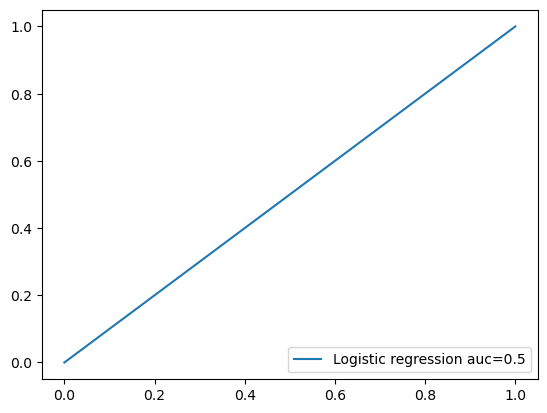

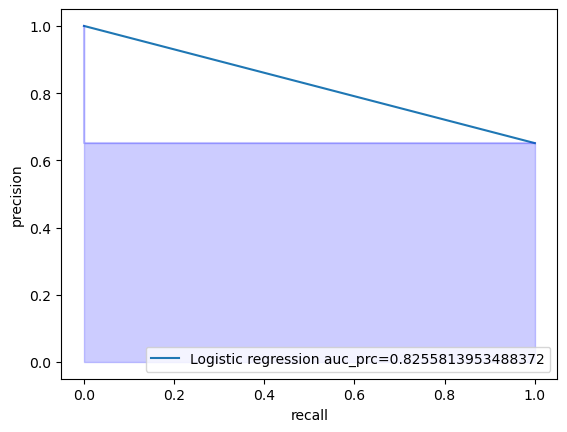

Train Result:
Accuracy Score: 50.00%
________________________________________________________________
CLASSIFICATION REPORT:
                    0      1  accuracy   macro avg  weighted avg
precision    0.500000    0.0       0.5    0.250000      0.250000
recall       1.000000    0.0       0.5    0.500000      0.500000
f1-score     0.666667    0.0       0.5    0.333333      0.333333
support    110.000000  110.0       0.5  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [110   0]]

Test Result:
Accuracy Score: 34.88%
________________________________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision   0.348837   0.0  0.348837   0.174419      0.121687
recall      1.000000   0.0  0.348837   0.500000      0.348837
f1-score    0.517241   0.0  0.348837   0.258621      0.180433
support    15.000000  28.0  0.348837  43.000000     43.000000
_______

In [30]:
###################### GRIDSEARCH ###########################################
logistic_Reg = LogisticRegression()

parameters = {                              #Definition of the parameters to test
    'max_iter': [50, 150, 300, 500,1000],
    'penalty' : ['l1','l2', 'elasticnet', 'none'], 
    'C': [0.1, 1, 10, 100, 1000],
    'solver' : ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs']
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(logistic_Reg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_2H,y_train_2H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################
# Logistic Regression model creation with the best parameters definites previously

logistic_Reg = LogisticRegression(**clf.best_params_).fit(X_train_2H, y_train_2H)

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_2H,logistic_Reg.predict_proba(X_test_2H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_2H, logistic_Reg.predict_proba(X_test_2H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = logistic_Reg.predict_proba(X_test_2H)[:,1]
pred_test_full +=pred_test

#Save the different results 
y_pred = logistic_Reg.predict(X_test_2H)

logistic_Reg_clf=print_auc(logistic_Reg,X_train_2H,y_train_2H,X_test_2H,y_test_2H,"Logistic regression")

logistic_Reg_cm=confusion_matrix(y_test_2H,logistic_Reg.predict(X_test_2H))

results_df = pd.DataFrame(data=[["Logistic Regression", logistic_Reg_clf["f1"], logistic_Reg_clf["auc"],logistic_Reg_clf["auc_pr"],
                                 logistic_Reg_clf["recall_sc"][0],logistic_Reg_clf["recall_sc"][1],logistic_Reg_clf["precision_sc"][0],logistic_Reg_clf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])

## 2. Random Classifier (RFC)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
learning done in 112.96 seconds


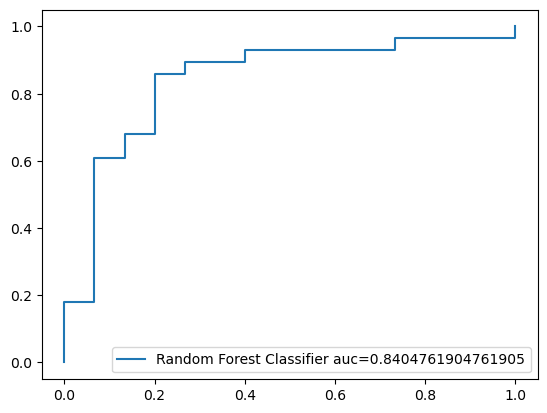

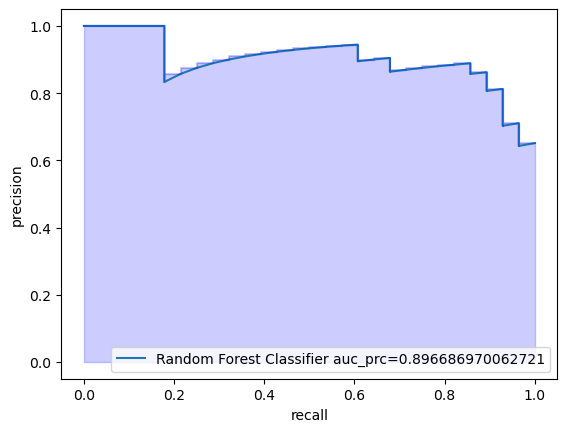

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 83.72%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.785714   0.862069  0.837209   0.823892      0.835434
recall      0.733333   0.892857  0.837209   0.813095      0.837209
f1-score    0.758621   0.877193  0.837209   0.817907      0.835831
support    15.000000  28.000000  0.837209  43.000000     43.000000
___________

In [31]:
###################### GRIDSEARCH ###########################################
RFC = RandomForestClassifier()

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(RFC,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_2H,y_train_2H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

RFC = RandomForestClassifier(**clf.best_params_).fit(X_train_2H, y_train_2H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_2H,RFC.predict_proba(X_test_2H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_2H, RFC.predict_proba(X_test_2H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = RFC.predict_proba(X_test_2H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = RFC.predict(X_test_2H)

clf_rdf=print_auc(RFC,X_train_2H,y_train_2H,X_test_2H,y_test_2H,"Random Forest Classifier") #Affichage de l'AUC
rdf_cm=confusion_matrix(y_test_2H,RFC.predict(X_test_2H))

#Save the results
results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", clf_rdf["f1"], clf_rdf["auc"],clf_rdf["auc_pr"],clf_rdf["recall_sc"][0],clf_rdf["recall_sc"][1],
                                   clf_rdf["precision_sc"][0],clf_rdf["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 3. XGBoost (XGB)

{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'nthread': 4, 'seed': 42, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
learning done in 119.03 seconds


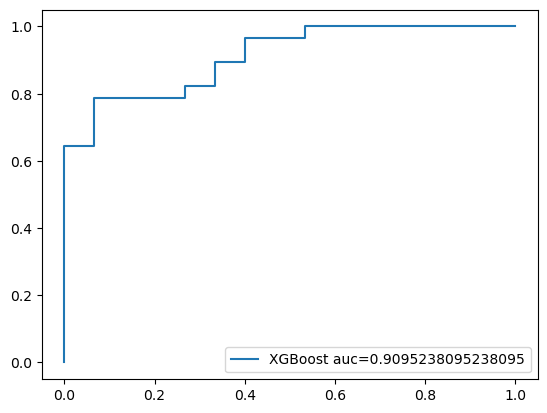

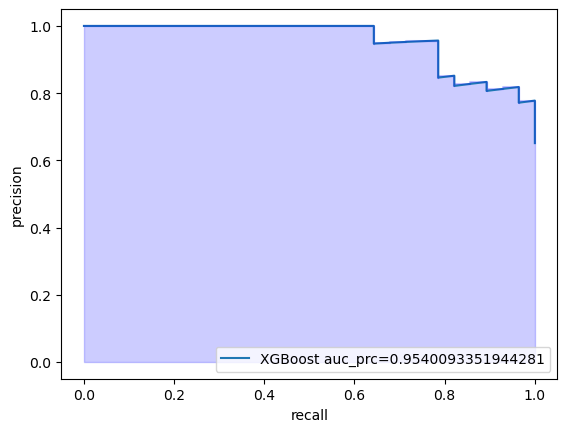

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 76.74%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.666667   0.821429  0.767442   0.744048      0.767442
recall      0.666667   0.821429  0.767442   0.744048      0.767442
f1-score    0.666667   0.821429  0.767442   0.744048      0.767442
support    15.000000  28.000000  0.767442  43.000000     43.000000
___________

In [32]:
###################### GRIDSEARCH ###########################################
XGB = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0
)

parameters = {                              #Definition of the parameters to test
            'max_depth':[3,5,10,None],
            'n_estimators':[10,100,200], # you can add 500 and None 
            'max_features':[1,3,5,7],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(XGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_2H,y_train_2H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

XGB=XGBClassifier(objective= 'binary:logistic',
    nthread=4,
    seed=42,
    verbosity=0,
    **clf.best_params_).fit(X_train_2H, y_train_2H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_2H,XGB.predict_proba(X_test_2H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_2H, XGB.predict_proba(X_test_2H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = XGB.predict_proba(X_test_2H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = XGB.predict(X_test_2H)

clf_xgb=print_auc(XGB,X_train_2H,y_train_2H,X_test_2H,y_test_2H,"XGBoost") #Affichage de l'AUC
xgb_cm=confusion_matrix(y_test_2H,XGB.predict(X_test_2H))

#Save the results
results_df_2 = pd.DataFrame(data=[["XGBoost", clf_xgb["f1"], clf_xgb["auc"],clf_xgb["auc_pr"],clf_xgb["recall_sc"][0],clf_xgb["recall_sc"][1],
                                   clf_xgb["precision_sc"][0],clf_xgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 4. LightGBM (LGB)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 20, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 2000, 'metric': 'auc'}
learning done in 316.21 seconds


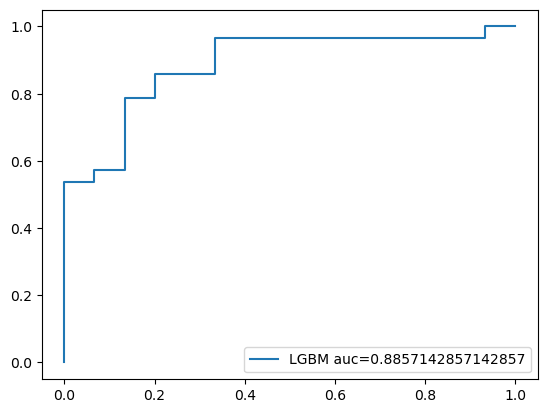

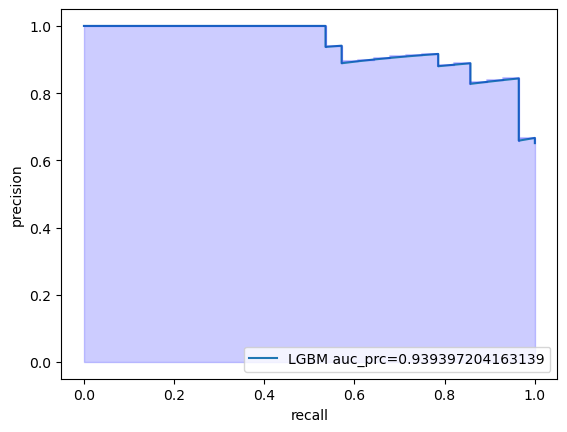

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 79.07%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.714286   0.827586  0.790698   0.770936      0.788063
recall      0.666667   0.857143  0.790698   0.761905      0.790698
f1-score    0.689655   0.842105  0.790698   0.765880      0.788925
support    15.000000  28.000000  0.790698  43.000000     43.000000
___________

In [33]:
###################### GRIDSEARCH ###########################################
LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                         objective='binary', 
                         num_boost_round=2000, 
                         learning_rate=0.01, 
                         metric='auc')

parameters = {'num_leaves':[20,40,60,80,100], 
            'min_child_samples':[5,10,15],
            'max_depth':[-1,5,10,20],
            'learning_rate':[0.05,0.1,0.2],
            'reg_alpha':[0,0.01,0.03]}

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(LGB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_2H,y_train_2H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

LGB = lgb.LGBMClassifier(boosting_type='gbdt',  
                        objective='binary', 
                        num_boost_round=2000, 
                        metric='auc',
                        **clf.best_params_).fit(X_train_2H, y_train_2H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_2H,LGB.predict_proba(X_test_2H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_2H, LGB.predict_proba(X_test_2H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = LGB.predict_proba(X_test_2H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = LGB.predict(X_test_2H)

clf_lgb=print_auc(LGB,X_train_2H,y_train_2H,X_test_2H,y_test_2H,"LGBM") #Affichage de l'AUC
lgb_cm=confusion_matrix(y_test_2H,LGB.predict(X_test_2H))

#Save the results
results_df_2 = pd.DataFrame(data=[["LGBM", clf_lgb["f1"], clf_lgb["auc"],clf_lgb["auc_pr"],clf_lgb["recall_sc"][0],clf_lgb["recall_sc"][1],
                                   clf_lgb["precision_sc"][0],clf_lgb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 5. SVC (svc)

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
learning done in 1.08 seconds


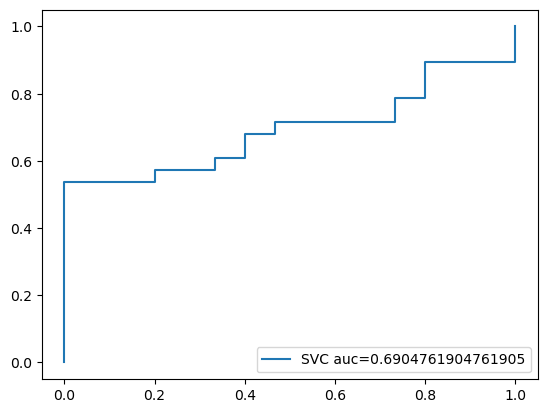

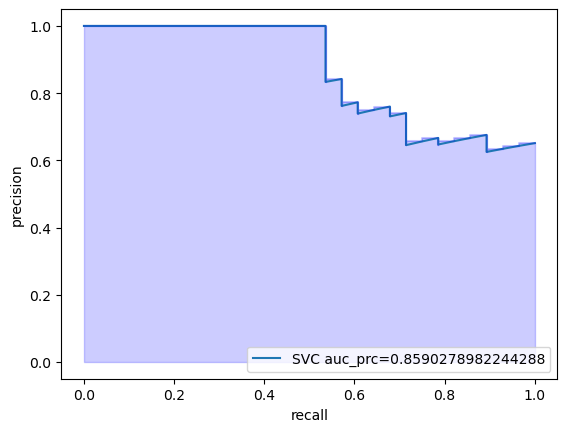

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 60.47%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.400000   0.666667  0.604651   0.533333      0.573643
recall      0.266667   0.785714  0.604651   0.526190      0.604651
f1-score    0.320000   0.721311  0.604651   0.520656      0.581319
support    15.000000  28.000000  0.604651  43.000000     43.000000
___________

In [34]:
###################### GRIDSEARCH ###########################################
svc = SVC(probability=True)

parameters = {'C':[1,10,100],
            'gamma':[1,0.1,0.001], 
            'kernel':['linear','rbf', 'sigmoid']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(svc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_2H,y_train_2H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

svc = SVC(**clf.best_params_, probability=True).fit(X_train_2H, y_train_2H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_2H,svc.predict_proba(X_test_2H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_2H, svc.predict_proba(X_test_2H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = svc.predict_proba(X_test_2H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = svc.predict(X_test_2H)

clf_svc=print_auc(svc,X_train_2H,y_train_2H,X_test_2H,y_test_2H,"SVC") #Affichage de l'AUC
svc_cm=confusion_matrix(y_test_2H,svc.predict(X_test_2H))

#Save the results
results_df_2 = pd.DataFrame(data=[["SVC", clf_svc["f1"], clf_svc["auc"],clf_svc["auc_pr"],clf_svc["recall_sc"][0],clf_svc["recall_sc"][1],
                                   clf_svc["precision_sc"][0],clf_svc["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 6. Naive Bayes (GNB)

{'priors': None, 'var_smoothing': 0.001}
learning done in 0.17 seconds


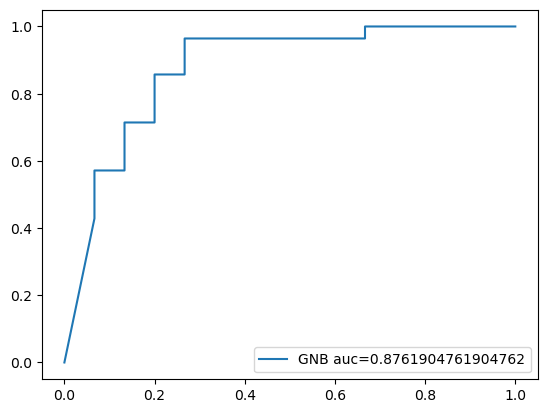

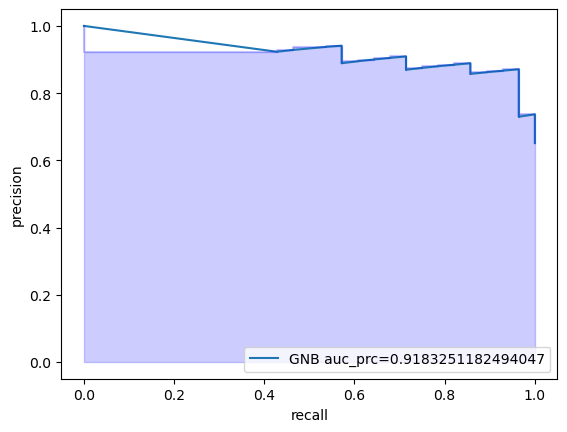

Train Result:
Accuracy Score: 72.73%
________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.681159    0.804878  0.727273    0.743019      0.743019
recall       0.854545    0.600000  0.727273    0.727273      0.727273
f1-score     0.758065    0.687500  0.727273    0.722782      0.722782
support    110.000000  110.000000  0.727273  220.000000    220.000000
________________________________________________________________
Confusion Matrix: 
 [[94 16]
 [44 66]]

Test Result:
Accuracy Score: 74.42%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.600000   0.869565  0.744186   0.734783      0.775531
recall      0.800000   0.714286  0.744186   0.757143      0.744186
f1-score    0.685714   0.784314  0.744186   0.735014      0.749919
support    15.000000  28.000

In [35]:
###################### GRIDSEARCH ###########################################
GNB = GaussianNB()

parameters = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
              
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(GNB,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_2H,y_train_2H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

GNB = GaussianNB(**clf.best_params_).fit(X_train_2H, y_train_2H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_2H,GNB.predict_proba(X_test_2H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_2H, GNB.predict_proba(X_test_2H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = GNB.predict_proba(X_test_2H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = GNB.predict(X_test_2H)

clf_gnb=print_auc(GNB,X_train_2H,y_train_2H,X_test_2H,y_test_2H,"GNB") #Affichage de l'AUC
gnb_cm=confusion_matrix(y_test_2H,GNB.predict(X_test_2H))

#Save the results
results_df_2 = pd.DataFrame(data=[["GNB",clf_gnb["f1"],clf_gnb["auc"],clf_gnb["auc_pr"],clf_gnb["recall_sc"][0],clf_gnb["recall_sc"][1],
                                   clf_gnb["precision_sc"][0],clf_gnb["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

## 7. KNN (KNN)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 18, 'p': 2, 'weights': 'distance'}
learning done in 16.83 seconds


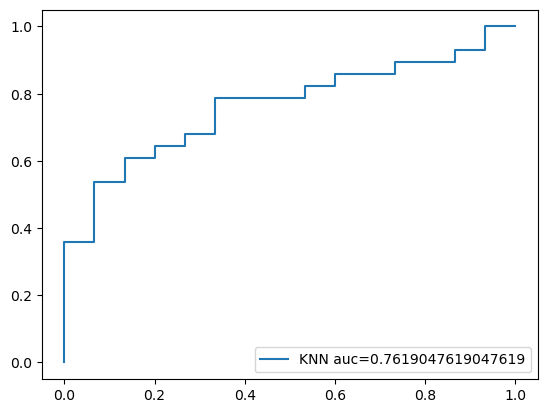

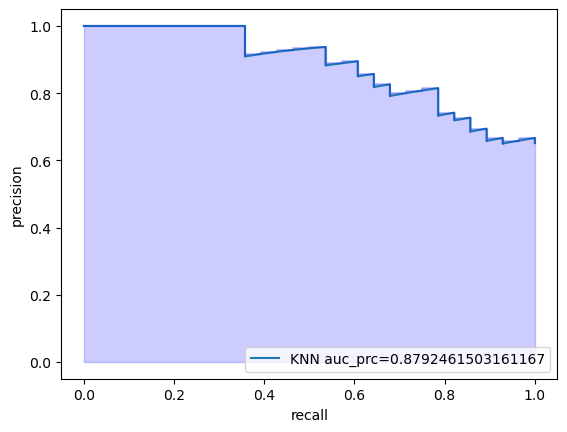

Train Result:
Accuracy Score: 100.00%
________________________________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    110.0  110.0       1.0      220.0         220.0
________________________________________________________________
Confusion Matrix: 
 [[110   0]
 [  0 110]]

Test Result:
Accuracy Score: 67.44%
________________________________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.523810   0.818182  0.674419   0.670996      0.715494
recall      0.733333   0.642857  0.674419   0.688095      0.674419
f1-score    0.611111   0.720000  0.674419   0.665556      0.682016
support    15.000000  28.000000  0.674419  43.000000     43.000000
___________

In [36]:
###################### GRIDSEARCH ###########################################
KNN = KNeighborsClassifier()

k_range = list(range(1, 31)) # Definition of number neighbors
parameters = {
            'n_neighbors' : k_range,
            'weights': ['uniform', 'distance'],
            'metric' : ['manhattan']
            }

# KFOLD definition with n splits
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) # n_split <=5

pred_test_full =0
cv_score =[] # Score list creation

time_start = time.perf_counter()

clf = GridSearchCV(KNN,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'roc_auc',    # metric for scoring 'average_precision' for auc_precision_recall
                   cv=kf)                     # number of folds
clf.fit(X_train_2H,y_train_2H)

print(clf.best_estimator_.get_params())

############## DEFINITION OF THE FINAL MODEL########################

KNN = KNeighborsClassifier(**clf.best_params_).fit(X_train_2H, y_train_2H) # best_params_ permit to take the best param definites by the gridsearch

time_elapsed = (time.perf_counter()-time_start)
print("learning done in %.2f seconds" %(time_elapsed))

######################## SCORE ###########################################
score = roc_auc_score(y_test_2H,KNN.predict_proba(X_test_2H)[:,1])

precision, recall, thresholds = precision_recall_curve(y_test_2H, KNN.predict_proba(X_test_2H)[:,1], pos_label='1')

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)

# Append the score in the CV_list
cv_score.append(score)    
# Append the pred_test in the pred_test list
pred_test = KNN.predict_proba(X_test_2H)[:,1]
pred_test_full +=pred_test

# Save the model 
y_pred = KNN.predict(X_test_2H)

clf_knn=print_auc(KNN,X_train_2H,y_train_2H,X_test_2H,y_test_2H,"KNN") #Affichage de l'AUC
knn_cm=confusion_matrix(y_test_2H,KNN.predict(X_test_2H))

#Save the results
results_df_2 = pd.DataFrame(data=[["KNN",clf_knn["f1"],clf_knn["auc"],clf_knn["auc_pr"],clf_knn["recall_sc"][0],clf_knn["recall_sc"][1],
                                   clf_knn["precision_sc"][0],clf_knn["precision_sc"][1]]], 
                        columns=['Model', 'f1', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df_2, ignore_index=True)

In [37]:
results_df.to_csv('results for 2H dataset.csv', index=True)